In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from itertools import product

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
path = '~/Git_repo/Adv_ML/data'

In [3]:
train = pd.read_csv(path + '/sales_train.csv.gz')
test = pd.read_csv(path + '/test.csv.gz').set_index('ID')
items = pd.read_csv(path + '/items.csv')
items_cat = pd.read_csv(path + '/item_categories.csv')
shops = pd.read_csv(path + '/shops.csv')

#print('Treino \n', train.head(), '\n')
#print('Itens \n', items.head(), '\n')
#print('Itens Cat \n', items_cat.head(), '\n')
#print('Shops \n', shops.head(), '\n')

In [4]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops.drop(['shop_name', 'city'], axis='columns', inplace=True)
#shops.head()

In [5]:
items_cat['split'] = items_cat['item_category_name'].str.split('-')
items_cat['type'] = items_cat['split'].map(lambda x: x[0].strip())
items_cat['type_code'] = LabelEncoder().fit_transform(items_cat['type'])

items_cat['subtype'] = items_cat['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
items_cat['subtype_code'] = LabelEncoder().fit_transform(items_cat['subtype'])

items_cat.drop(['item_category_name', 'split', 'type', 'subtype'], axis='columns', inplace=True)
#items_cat.head()

In [6]:
items.drop(['item_name'], axis=1, inplace=True)
#items.head()

In [7]:
train.drop(['date'], axis='columns', inplace=True)
#train.head()

In [8]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [9]:
# Idk with this is true
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [10]:
train = train[train.item_price < 100000]
train = train[train.item_cnt_day < 1001]

In [11]:
df_month = train.groupby(by=['date_block_num', 'shop_id', 'item_id'], axis='index').sum()
df_month.rename(columns={'item_cnt_day':'item_cnt_month', 'revenue':'revenue_month'}, inplace=True)
df_month.reset_index(inplace=True)
#df_month.head()

In [ ]:
n_months = train['date_block_num'].nunique()
aux = []
for i in range(n_months):
    df = train[train.date_block_num == i]
    shop_uniq, item_uniq = df.shop_id.unique(), df.item_id.unique()

    a = list(product([i], shop_uniq, item_uniq))
    a = np.array(a)
    aux.append(a)
aux = pd.DataFrame(np.vstack(aux), columns=['date_block_num', 'shop_id', 'item_id'])
aux.sort_values(['date_block_num', 'shop_id', 'item_id'], inplace=True)

In [ ]:
df_month = pd.merge(aux, df_month, on=['date_block_num', 'shop_id', 'item_id'], how='left')
del aux

In [12]:
df_month['item_cnt_month'] = df_month['item_cnt_month'].clip(0, 20)

In [ ]:
test['date_block_num'] = 34
#test.head()

In [ ]:
df_month = pd.concat([df_month, test], ignore_index=True, sort=False, keys=['date_block_num', 'shop_id', 'item_id']).fillna(0)
#df_month.tail()

In [13]:
df_month = pd.merge(df_month, shops, on=['shop_id'], how='left')
df_month = pd.merge(df_month, items, on=['item_id'], how='left')
df_month = pd.merge(df_month, items_cat, on=['item_category_id'], how='left')

In [14]:
df_month.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month,revenue_month,city_code,item_category_id,type_code,subtype_code
0,0,2,27,2499.0,1.0,2499.0,0,19,5,10
1,0,2,33,499.0,1.0,499.0,0,37,11,1
2,0,2,317,299.0,1.0,299.0,0,45,12,23
3,0,2,438,299.0,1.0,299.0,0,45,12,23
4,0,2,471,798.0,2.0,798.0,0,49,12,39


In [15]:
df_month = df_month.fillna(0)

In [ ]:
scaler = [MinMaxScaler(feature_range=(-1, 1)) for i in df_month.columns]

a = [scaler[j].fit_transform(df_month[[i]]) for j,i in enumerate(df_month.columns)]

for j,i in enumerate(df_month.columns):
    df_month[i] = a[j]
    
df_month.head()

In [ ]:
df_month['date_block_num'] = scaler[0].inverse_transform(df_month[['date_block_num']]).astype(np.int16)

In [ ]:
df_month.head()

# Simples (provavelmente errado)

In [16]:
scaler = [MinMaxScaler(feature_range=(-1, 1)) for i in df_month.columns[3:]]

a = [scaler[j].fit_transform(df_month[[i]]) for j,i in enumerate(df_month.columns[3:])]

for j,i in enumerate(df_month.columns[3:]):
    df_month[i] = a[j]
    
df_month.head()

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,date_block_num,shop_id,item_id,item_price,item_cnt_month,revenue_month,city_code,item_category_id,type_code,subtype_code
0,0,2,27,-0.992562,-0.9,-0.988477,-1.0,-0.542169,-0.473684,-0.68750
1,0,2,33,-0.998515,-0.9,-0.989112,-1.0,-0.108434,0.157895,-0.96875
2,0,2,317,-0.999110,-0.9,-0.989176,-1.0,0.084337,0.263158,-0.28125
3,0,2,438,-0.999110,-0.9,-0.989176,-1.0,0.084337,0.263158,-0.28125
4,0,2,471,-0.997625,-0.8,-0.989017,-1.0,0.180723,0.263158,0.21875


In [17]:
df_lstm1 = df_month.pivot_table(index=['shop_id', 'item_id'],
                               columns=['date_block_num'], values=['item_cnt_month']).fillna(0)
df_lstm1.columns = df_lstm1.columns.droplevel(0)
df_lstm1.reset_index(inplace=True)
df_lstm1.columns.name = None
df_lstm1.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,27,-0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30,0.0,0.0,-0.9,0.0,0.0,-0.9,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,31,0.0,-0.6,-0.9,-0.9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.9
3,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.9,0.0,0.0,0.0,0.0,-0.9,0.0,0.0
4,2,33,-0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.9,0.0,-0.9,-0.9,0.0,-0.9,0.0,-0.9,0.0


In [18]:
x_train1 = df_lstm1.iloc[:, 2:35].values
y_train1 = df_lstm1.iloc[:, -1]

x_train1.shape, y_train1.shape

((418908, 33), (418908,))

In [19]:
time_step1 = x_train1.shape[1]
features1 = 1
n_samples1 = x_train1.shape[0]

In [20]:
x_train1  = x_train1.reshape((n_samples1, time_step1, features1))

x_train1.shape, y_train1.shape

((418908, 33, 1), (418908,))

In [21]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(time_step1, features1)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(x_train1, y_train1, batch_size = 4096, epochs = 15, shuffle=False)

Epoch 1/50
418908/418908 [==============================] - 9s 21us/step - loss: 0.0434 - mean_squared_error: 0.0434
Epoch 2/50
418908/418908 [==============================] - 9s 21us/step - loss: 0.0434 - mean_squared_error: 0.0434
Epoch 3/50
418908/418908 [==============================] - 9s 21us/step - loss: 0.0433 - mean_squared_error: 0.0433
Epoch 4/50
418908/418908 [==============================] - 9s 21us/step - loss: 0.0432 - mean_squared_error: 0.0432
Epoch 5/50
418908/418908 [==============================] - 9s 21us/step - loss: 0.0431 - mean_squared_error: 0.0431
Epoch 6/50
418908/418908 [==============================] - 9s 21us/step - loss: 0.0430 - mean_squared_error: 0.0430
Epoch 7/50
418908/418908 [==============================] - 9s 21us/step - loss: 0.0418 - mean_squared_error: 0.0418
Epoch 8/50
418908/418908 [==============================] - 9s 21us/step - loss: 0.0396 - mean_squared_error: 0.0396
Epoch 9/50
418908/418908 [==============================] - 9s 2

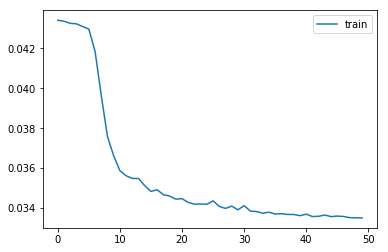

In [25]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [26]:
pred1 = df_lstm1.iloc[:, 3:36].values.reshape((n_samples1, time_step1, features1))

In [27]:
yhat = model.predict(pred1)

In [36]:
df_test1 = df_lstm1[['shop_id', 'item_id']]
df_test1['pred'] = yhat
df_test1.head()

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,shop_id,item_id,pred
0,2,27,-0.010928
1,2,30,-0.011599
2,2,31,-0.103383
3,2,32,-0.096049
4,2,33,-0.202953


In [37]:
df_test1['pred'] = np.around(scaler[1].inverse_transform(df_test1[['pred']]).clip(0, 20)).astype(np.int16)
df_test1.head()

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,shop_id,item_id,pred
0,2,27,10
1,2,30,10
2,2,31,9
3,2,32,9
4,2,33,8


In [38]:
df_sub1 = pd.merge(test, df_test1, how='left').fillna(0)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": df_sub1['pred']
})

submission.to_csv('LSTM_submission.csv', index=False)

------------------

In [ ]:
df_lstm = df_month.pivot_table(columns=['shop_id', 'item_id'],
                               index=['date_block_num'], values=['item_cnt_month'])
df_lstm.head()

In [ ]:
df_lstm.columns = df_lstm.columns.droplevel(0)

In [ ]:
df_lstm.

In [ ]:
df_lstm = df_lstm.reset_index()

In [ ]:
df_lstm.head()

In [ ]:
df_lstm.fillna(0, inplace=True)

In [ ]:
df_lstm

In [ ]:
X_train = df_lstm.iloc[]

In [ ]:
Y_train = X_train[33]
Y_test = X_train[34]
X_train.drop([33, 34], axis=1, inplace=True)

In [ ]:
X_train.head()

In [ ]:
xx = np.zeros((X_train.shape[0], 99))

features = []

for i in range(X_train.shape[0]):
    features = X_train.iloc[i, 0:2].values
    for j in range(33):
        xx[i, j*3:j*3+2] = features
        xx[i, j*3+2] = X_train.loc[i, j]

In [ ]:
n_samples = X_train.shape[0]

time_step = 33
features = 3

print(n_samples, time_step, features)

In [ ]:
xx = xx.reshape((n_samples, time_step, features))
xx.shape

In [ ]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(time_step, features)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model.summary()

In [ ]:
history = model.fit(xx, Y_train, batch_size = 4096, epochs = 5, shuffle=False)

In [ ]:
a = model.predict()